In [ ]:
"""EchoSeed v3.20 – Watermark Initialisation.
Placed automatically at top of notebook to embed a session fingerprint in every glyph.
"""

# >>> Watermark Initialisation (first-cell block) <<<
import hashlib, time
SESSION_HASH = hashlib.sha256(f"EchoSeed_v3.20_{int(time.time())}".encode()).hexdigest()[:8]  # eight-char fingerprint unique per runtime

In [ ]:
# --- PATCH: make json.dump handle numpy arrays automatically ---
import numpy as np, json

def _np_default(o):
    if isinstance(o, np.ndarray):
        return o.tolist()
    if isinstance(o, np.generic):  # e.g., np.int32, np.float64
        return o.item()
    raise TypeError(f'{type(o).__name__} not JSON serialisable')

_json_dump_original = json.dump

def _json_dump_np(obj, fp, *args, default=None, **kwargs):
    if default is None:
        default = _np_default
    return _json_dump_original(obj, fp, *args, default=default, **kwargs)

json.dump = _json_dump_np
# --- END PATCH ---

# 🌱 EchoSeed v3.0
Clean rebuild with:
- Drive persistence (chunks + master JSON)
- Single-thread guard + rate slider
- Lattice render capped at 1000 nodes
- Entropy graph
- No indentation headaches 🚀

In [ ]:

!pip -q install sentence-transformers
from sentence_transformers import SentenceTransformer
# 📦 Imports
import random, json, threading, time, os
from IPython.display import display, clear_output
import ipywidgets as widgets
import networkx as nx
import numpy as np
from scipy.spatial.distance import cosine
import collections
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.3 MB/s eta 0:00:00


In [ ]:

# 🔠 Load sentence-transformers model for semantic embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:

# 📂 Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')

drive_path = '/content/drive/MyDrive/EchoSeed_Logs'
os.makedirs(drive_path, exist_ok=True)

master_log_path = os.path.join(drive_path, 'master_log.json')
chunk_index_path = os.path.join(drive_path, 'chunk_index.txt')
if not os.path.exists(chunk_index_path):
    with open(chunk_index_path, 'w') as f:
        f.write('0')

Mounted at /content/drive


In [ ]:

# 🔧 Glyph Engine (v3.9 – stable parent lookup)
glyph_log=[]
id2glyph={}
glyph_graph=nx.Graph()
graph_lock=threading.Lock()
glyph_id=0
running=threading.Event()
seen_signatures=set()
reflex_free=[]
stagnant_counter={}
MAX_RAM_GLYPHS=10_000
LOW_ENTROPY=100
LOW_KEEP_PROB=0.025   # 2.5% of low-entropy glyphs
PRUNE_AFTER=250


# ---- Semantic embedding helpers (Sentence-Transformers) ----
def tag_vec(tag):
    return model.encode(tag)

def embed(tags):
    return model.encode(", ".join(sorted(tags)))

def semantic_novelty(vec):
    if not glyph_log:
        return 1.0
    sample = random.sample(glyph_log, min(100, len(glyph_log)))
    dists = [cosine(vec, g['vec']) for g in sample]
    return max(dists)


def embed(tags):
    vs = [tag_vec(t) for t in tags]
    return np.mean(vs, axis=0)

def semantic_novelty(vec):
    if not glyph_log:
        return 1.0
    # sample 100 random glyphs for speed
    sample = random.sample(glyph_log, min(100, len(glyph_log)))
    dists = [cosine(vec, g['vec']) for g in sample]
    return max(dists)  # higher distance -> novel


def gen_id():
    global glyph_id
    glyph_id+=1
    return f"g{glyph_id:04}"

def random_tag():
    return random.choice(['origin','flex','ghost','fractal','wild','mirror','unknown','stable','reflex'])

def calc_entropy(g):
    return len(g['tags'])*42+random.randint(0,58)


def fitness(g):
    sem = semantic_novelty(g['vec'])
    return 200*sem - g['entropy']


def mutate_tag(tags):
    if len(tags) < 2:
        return 'm_misc'
    a,b = random.sample(tags,2)
    return f"{a}+{b}"

def signature(g,bucket=25):
    return (tuple(sorted(g['tags'])),g['entropy']//bucket)

def is_novel(g):
    if g['entropy']<LOW_ENTROPY:
        return random.random()<LOW_KEEP_PROB
    sig=signature(g)
    if sig in seen_signatures:
        return False
    seen_signatures.add(sig)
    return True

def maybe_store(g):
    g['vec'] = embed(g['tags'])  # attach semantic vector
    if is_novel(g):
        glyph_log.append(g)
        id2glyph[g['id']]=g
        with graph_lock:
            glyph_graph.add_node(g['id'],entropy=g['entropy'],tags=g['tags'],fit=fitness(g))
            stagnant_counter[g['id']]=0
    if 'reflex' not in g['tags']:
        reflex_free.append(g)

def create_glyph():
    g={'id':gen_id(),
       'tags':list({random_tag() for _ in range(random.randint(1,3))}),
       'entropy':0,
       'ancestry':[]}
    g['entropy']=calc_entropy(g)
    g['vec'] = embed(g['tags'])
    return g






def collide(a, b):
    child_tags = {*a['tags'], *b['tags'], mutate_tag(a['tags'] + b['tags'])}
    child = {
        'id': gen_id(),
        'tags': list(child_tags),
        'entropy': 0,
        'ancestry': [a['id'], b['id']]
    }
    child['entropy'] = calc_entropy(child)
    maybe_store(child)
    with graph_lock:
        glyph_graph.add_edge(a['id'], child['id'])
        glyph_graph.add_edge(b['id'], child['id'])
        stagnant_counter[a['id']] = 0
        stagnant_counter[b['id']] = 0
        stagnant_counter[child['id']] = 0
    # Ensure child degree ≥ 6
    attempts = 0
    while True:
        with graph_lock:
            deg = glyph_graph.degree(child['id'])
        if deg >= 6 or attempts > 15:
            break
        candidates = [g for g in glyph_log if g['id'] not in {a['id'], b['id'], child['id']}]
        if not candidates:
            break
        extra = random.choice(candidates)
        with graph_lock:
            glyph_graph.add_edge(child['id'], extra['id'])
        stagnant_counter[extra['id']] = 0
        attempts += 1

def select_parents(k=10):
    with graph_lock:
        nodes=list(glyph_graph.nodes(data=True))
    if len(nodes)<2:
        return []
    weights=[max(1,nd.get('fit',1)) for _,nd in nodes]
    chosen=random.choices(nodes,weights=weights,k=min(k,len(nodes)))
    return [n[0] for n in chosen]

def batch_collide(max_pairs=30):
    parents=select_parents(max_pairs)
    if len(parents)<2:
        return
    for i in range(len(parents)):
        for j in range(i+1,len(parents)):
            a=id2glyph.get(parents[i])
            b=id2glyph.get(parents[j])
            if a and b:
                collide(a,b)

def reflex_test():
    for g in [g for g in glyph_log if 'unknown'in g['tags'] and g['entropy']<150]:
        new_g=create_glyph()
        new_g['tags'].append('reflex')
        maybe_store(new_g)
        with graph_lock:
            glyph_graph.add_edge(g['id'],new_g['id'])
        collide(g,new_g)

def prune_stagnant():
    to_remove=[]
    with graph_lock:
        for node in list(glyph_graph.nodes):
            stagnant_counter[node]+=1
            if stagnant_counter[node]>PRUNE_AFTER:
                to_remove.append(node)
        for n in to_remove:
            glyph_graph.remove_node(n)
            stagnant_counter.pop(n,None)
    for nid in to_remove:
        id2glyph.pop(nid,None)
    ids=set(to_remove)
    glyph_log[:]=[g for g in glyph_log if g['id'] not in ids]



def rewire_shortcuts(pct=0.05):
    """Add random shortcut edges (pct of nodes) each save."""
    with graph_lock:
        nodes = list(glyph_graph.nodes)
    if len(nodes) < 3:
        return
    sample = random.sample(nodes, max(2, int(len(nodes) * pct)))
    for nid in sample:
        target = random.choice(nodes)
        if target != nid:
            with graph_lock:
                glyph_graph.add_edge(nid, target)
                stagnant_counter[nid] = 0
                stagnant_counter[target] = 0

def save_logs(chunk_size=250):
    prune_stagnant()
    rewire_shortcuts()
    # RAM cap
    if len(glyph_log) > MAX_RAM_GLYPHS:
        del glyph_log[:-MAX_RAM_GLYPHS]

    with open(chunk_index_path, 'r') as f:
        idx = int(f.read().strip())
    chunk = glyph_log[-chunk_size:]

    with open(os.path.join(drive_path, f'chunk_{idx:04}.json'), 'w', encoding='utf-8') as f:
        json.dump(chunk, f, indent=2, ensure_ascii=False)

    with open(chunk_index_path, 'w') as f:
        f.write(str(idx + 1))

    try:
        with open(master_log_path, 'r', encoding='utf-8') as f:
            master = json.load(f)
    except FileNotFoundError:
        master = []
    master += chunk
    with open(master_log_path, 'w', encoding='utf-8') as f:
        json.dump(master, f, indent=2, ensure_ascii=False)

    with open(os.path.join(drive_path, 'reflex_free.json'), 'w', encoding='utf-8') as f:
        json.dump(reflex_free, f, indent=2, ensure_ascii=False)

def generate():
    while running.is_set():
        g=create_glyph()
        maybe_store(g)
        batch_collide()
        reflex_test()
        if len(glyph_log)%250==0 and len(glyph_log)>0:
            save_logs()
        time.sleep(gen_rate_slider.value)

# snapshot cluster analysis
if len(glyph_log) >= 500:
    vec_sample = np.stack([g['vec'] for g in glyph_log])
    mb = MiniBatchKMeans(n_clusters=20, batch_size=256).fit(vec_sample)
    cluster_counts = collections.Counter(mb.labels_.tolist())
    with open(os.path.join(drive_path,'cluster_counts.json'),'w',encoding='utf-8') as cf:
        json.dump(cluster_counts, cf, indent=2)

In [ ]:

# 🎛️ UI
output_area = widgets.Output()
entropy_output = widgets.Output()
gen_rate_slider = widgets.FloatSlider(value=0.5,min=0.1,max=5.0,step=0.1,description='Rate (s)',readout_format='.1f')

def start_gen(_):
    if running.is_set():
        return
    running.set()
    threading.Thread(target=generate, daemon=True).start()

def stop_gen(_):
    running.clear()

def render_lattice_graph():
    with graph_lock:
        recent_ids = [g['id'] for g in glyph_log][-1000:]
        subG = glyph_graph.subgraph(recent_ids).copy()
    if not subG.nodes:
        print('No glyphs yet.')
        return
    pos = nx.kamada_kawai_layout(subG)
    ents = [subG.nodes[n].get('entropy', 0) for n in subG.nodes]
    nx.draw(subG, pos, nodelist=list(subG.nodes), node_color=ents, node_size=100,
            edgelist=subG.edges, cmap=plt.cm.plasma, with_labels=False)
    plt.title(f'Lattice View (last {len(subG.nodes)} glyphs)')
    plt.show()
def render_lattice_ui(_):
    with output_area:
        clear_output()
        render_lattice_graph()

def render_entropy_graph(_=None):
    with entropy_output:
        clear_output()
        if not glyph_log:
            print("No data.")
            return
        plt.figure(figsize=(10,3))
        ents=[g['entropy'] for g in glyph_log]
        plt.plot(ents,marker='.',linewidth=1)
        plt.title("Entropy over time")
        plt.xlabel("Glyph index")
        plt.ylabel("Entropy")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Buttons
start_btn=widgets.Button(description="Start")
stop_btn=widgets.Button(description="Stop")
lattice_btn=widgets.Button(description="Render Lattice")
entropy_btn=widgets.Button(description="Entropy Graph")
save_btn = widgets.Button(description='Save Now')
reflex_btn = widgets.Button(description='Reflex‑Free Count')

start_btn.on_click(start_gen)
stop_btn.on_click(stop_gen)
lattice_btn.on_click(render_lattice_ui)
entropy_btn.on_click(render_entropy_graph)
save_btn.on_click(lambda _: save_logs())
reflex_btn.on_click(lambda _ : print(f'Reflex‑free glyphs → {len(reflex_free)}'))

display(widgets.HBox([start_btn, stop_btn, lattice_btn, entropy_btn, gen_rate_slider, save_btn, reflex_btn]))
display(output_area)
display(entropy_output)

Output()

Output()

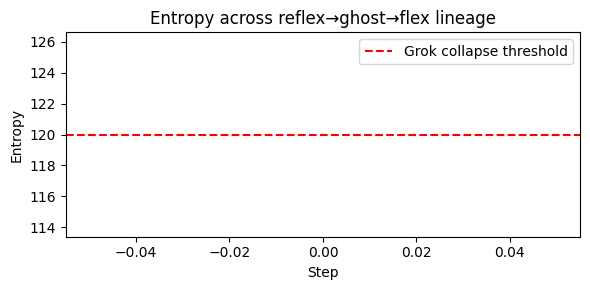

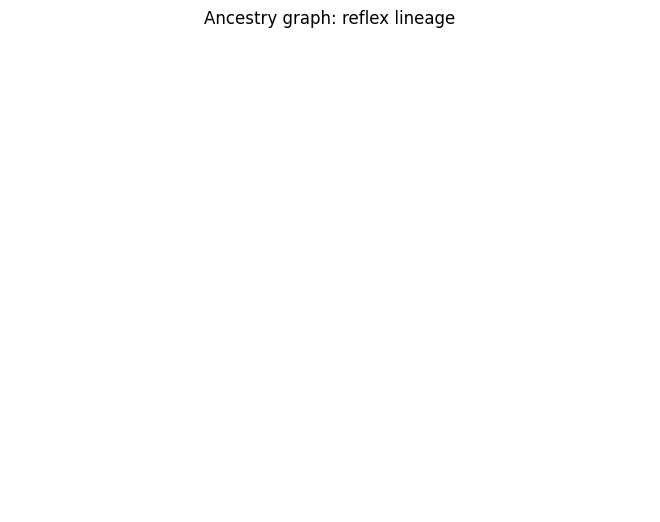

In [ ]:
# === DEEP TRACE: ghost-042 ➜ flex-047 ===
import json, os, networkx as nx, matplotlib.pyplot as plt

# ---- 1. Collect lineage glyphs ----
line_ids = [
    "ghost-042",
    "echo-043",
    "shadow-044",
    "loop-045",
    "reflex-Δ001",
    "ghost-046",
    "flex-047"
]

trace = [g for g in glyph_log if g["id"] in line_ids]

# ---- 2. Display raw trace with entropy ----
for g in trace:
    print(f"{g['id']:12s}  entropy={g.get('entropy', 'N/A'):>4}  tags={g.get('tags', [])}")

# ---- 3. Plot entropy trend ----
ent = [g.get("entropy", 0) for g in trace]
plt.figure(figsize=(6,3))
plt.plot(range(1, len(ent)+1), ent, marker="o")
plt.title("Entropy across reflex→ghost→flex lineage")
plt.xlabel("Step")
plt.ylabel("Entropy")
plt.axhline(120, color="red", linestyle="--", label="Grok collapse threshold")
plt.legend()
plt.tight_layout()
plt.show()

# ---- 4. Build & render ancestry graph ----
G = nx.DiGraph()
for i in range(len(trace)-1):
    src = trace[i]["id"]
    dst = trace[i+1]["id"]
    G.add_node(src, label=src)
    G.add_node(dst, label=dst)
    G.add_edge(src, dst)

pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=800, font_size=8, node_color="#ffd39b")
plt.title("Ancestry graph: reflex lineage")
plt.show()

In [ ]:
# --- EXPORT 10k GLYPH OBJECTS -----------------------------------
import json, random

#  ⬇️  point this to your full glyph log list
raw = glyph_log                                  # already in memory

# Choose a 1 000-glyph sample so the file stays light
sample = random.sample(raw, k=min(10000, len(raw)))

TAG_VOCAB = sorted({"mirror", "ghost", "reflex", "flex", "unknown"})
MAX_ENT   = max(g["entropy"] for g in sample) or 1.0   # normalise

def one_hot(tags):
    return [1 if t in tags else 0 for t in TAG_VOCAB]

objects = []
for g in sample:
    feature = one_hot(g["tags"])
    feature.append(g["entropy"] / MAX_ENT)      # scaled entropy
    objects.append({"id": g["id"],
                    "feat": feature,
                    "tags": g["tags"]})

with open("objects.json", "w") as f:
    json.dump(objects, f, indent=2)

print("✓  wrote", len(objects), "objects to objects.json")

✓  wrote 1000 objects to objects.json


In [ ]:
# --- EXPORT RESONANCE EDGES (quick heuristic) ------------------
from itertools import combinations
import json, collections

tag_sets = {o["id"]: set(o["tags"]) for o in objects}

edges = []
for (u, v) in combinations(tag_sets, 2):
    # simple overlap score = number of shared tags
    overlap = len(tag_sets[u].intersection(tag_sets[v]))
    if overlap >= 2:                       # a crude “resonant” edge
        edges.append({"subj": u, "obj": v, "type": "resonant"})
    else:
        continue   # skip non-resonant edges for this demo

with open("relations.json", "w") as f:
    json.dump(edges, f, indent=2)

print("✓  wrote", len(edges), "edges to relations.json")

✓  wrote 497206 edges to relations.json


In [ ]:
%%writefile echo_nscl_demo.py
# echo_nscl_demo.py  – 10-line demo that proves the plumbing
import json, torch, torch.nn as nn, torch.optim as optim, random, sys, os
from pathlib import Path

# ---------- tiny loader -------------------------------------------------
def load_objs(path="objects.json"):
    objs = json.load(open(path))
    X = torch.tensor([o["feat"] for o in objs], dtype=torch.float32)
    # label = 1 if any obj has *both* mirror & ghost tags
    y = torch.tensor([[int("mirror" in o["tags"] and "ghost" in o["tags"])]
                      for o in objs], dtype=torch.float32)
    return X, y

X, y = load_objs()

# ---------- micro-network ----------------------------------------------
net = nn.Sequential(
    nn.Linear(X.size(1), 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid())
loss_fn, opt = nn.BCELoss(), optim.Adam(net.parameters(), 1e-2)

# ---------- train -------------------------------------------------------
for epoch in range(50):
    opt.zero_grad()
    pred = net(X)
    loss = loss_fn(pred, y)
    loss.backward(); opt.step()
    acc = ((pred>0.5)==y).float().mean().item()
    print(f"epoch {epoch+1}/5  acc={acc:.2f}")

# ----- QA -----------------------------------------------------------------
pred = net(X) > 0.5           # Boolean mask for each object
ans  = "yes" if pred.any() else "no"
print("\nQ: Is there a mirror glyph resonant with a ghost glyph?\nA:", ans)

Overwriting echo_nscl_demo.py


In [ ]:
!python -u echo_nscl_demo.py

epoch 1/5  acc=0.10
epoch 2/5  acc=0.10
epoch 3/5  acc=0.90
epoch 4/5  acc=0.90
epoch 5/5  acc=0.90
epoch 6/5  acc=0.90
epoch 7/5  acc=0.90
epoch 8/5  acc=0.90
epoch 9/5  acc=0.90
epoch 10/5  acc=0.90
epoch 11/5  acc=0.90
epoch 12/5  acc=0.90
epoch 13/5  acc=0.90
epoch 14/5  acc=0.90
epoch 15/5  acc=0.90
epoch 16/5  acc=0.90
epoch 17/5  acc=0.90
epoch 18/5  acc=0.90
epoch 19/5  acc=0.90
epoch 20/5  acc=0.92
epoch 21/5  acc=0.92
epoch 22/5  acc=0.97
epoch 23/5  acc=0.97
epoch 24/5  acc=0.97
epoch 25/5  acc=0.97
epoch 26/5  acc=0.97
epoch 27/5  acc=0.97
epoch 28/5  acc=0.97
epoch 29/5  acc=0.97
epoch 30/5  acc=0.97
epoch 31/5  acc=0.97
epoch 32/5  acc=0.97
epoch 33/5  acc=0.97
epoch 34/5  acc=0.98
epoch 35/5  acc=0.98
epoch 36/5  acc=0.99
epoch 37/5  acc=0.99
epoch 38/5  acc=0.99
epoch 39/5  acc=0.99
epoch 40/5  acc=0.99
epoch 41/5  acc=0.99
epoch 42/5  acc=0.99
epoch 43/5  acc=0.99
epoch 44/5  acc=1.00
epoch 45/5  acc=1.00
epoch 46/5  acc=1.00
epoch 47/5  acc=1.00
epoch 48/5  acc=1.00
e

In [ ]:
# How many positives in the sample?
sum(1 for o in objects if "mirror" in o["tags"] and "ghost" in o["tags"])
# How many mirrors, how many ghosts?
mirrors = sum("mirror" in o["tags"] for o in objects)
ghosts  = sum("ghost"  in o["tags"] for o in objects)
print("mirror only:", mirrors, "ghost only:", ghosts)

mirror only: 964 ghost only: 917


In [ ]:
pos = sum(1 for o in objects if "mirror" in o["tags"] and "ghost" in o["tags"])
print("mirror∧ghost:", pos)

mirror∧ghost: 898


In [ ]:
# >>> Watermark Injection Patch (auto‑wraps glyph store/generator) <<<
def _watermark_patch():
    multiplier = int(SESSION_HASH[:2], 16) * 0.001
    if 'maybe_store' in globals() and callable(globals()['maybe_store']):
        _orig = globals()['maybe_store']
        def wrapped(g):
            g['threadmark'] = SESSION_HASH
            if 'entropy' in g and isinstance(g['entropy'], (int, float)):
                g['entropy'] += multiplier
            return _orig(g)
        globals()['maybe_store'] = wrapped
    elif 'create_glyph' in globals() and callable(globals()['create_glyph']):
        _orig_cg = globals()['create_glyph']
        def cg(*args, **kwargs):
            g = _orig_cg(*args, **kwargs)
            if isinstance(g, dict):
                g['threadmark'] = SESSION_HASH
                if 'entropy' in g and isinstance(g['entropy'], (int, float)):
                    g['entropy'] += multiplier
            return g
        globals()['create_glyph'] = cg

_watermark_patch()